  0%|          | 0/1 [00:00<?, ?it/s]

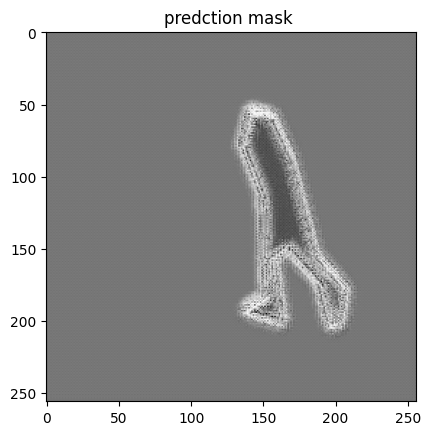

mask_loss = 0.8923315405845642, ordinary diffusion loss =0.13640181720256805


100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


Epoch 1 finished with loss 0.1453


  0%|          | 0/1 [00:00<?, ?it/s]

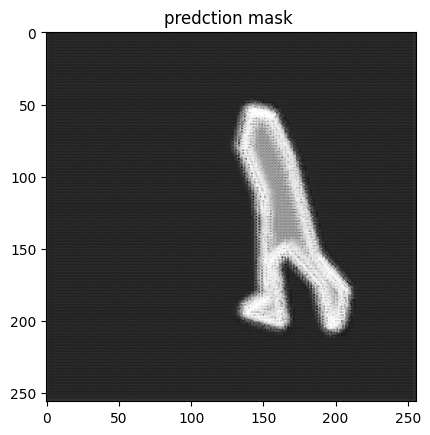

mask_loss = 0.8551921844482422, ordinary diffusion loss =0.25900277495384216


100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


Epoch 2 finished with loss 0.2676


  0%|          | 0/1 [00:00<?, ?it/s]

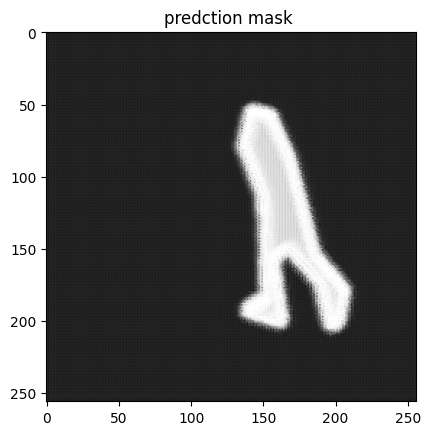

mask_loss = 0.8477052450180054, ordinary diffusion loss =0.1161908432841301


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Epoch 3 finished with loss 0.1247


  0%|          | 0/1 [00:00<?, ?it/s]

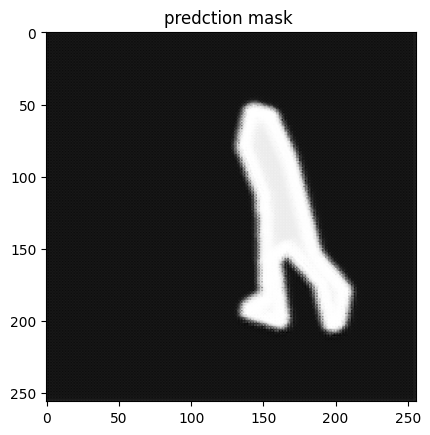

mask_loss = 0.8411872982978821, ordinary diffusion loss =0.10470565408468246


100%|██████████| 1/1 [00:13<00:00, 13.43s/it]


Epoch 4 finished with loss 0.1131


  0%|          | 0/1 [00:00<?, ?it/s]

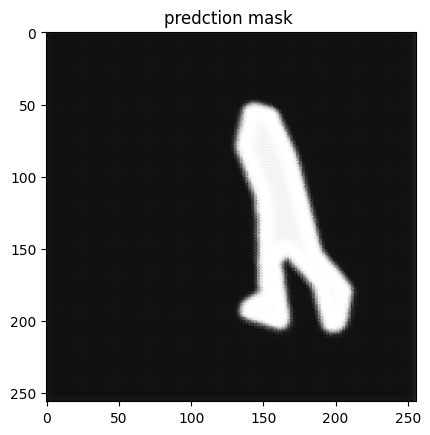

mask_loss = 0.8404016494750977, ordinary diffusion loss =0.0983235239982605


100%|██████████| 1/1 [00:13<00:00, 13.78s/it]


Epoch 5 finished with loss 0.1067


  0%|          | 0/1 [00:00<?, ?it/s]

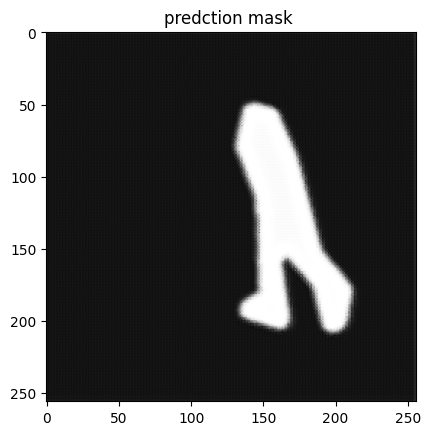

mask_loss = 0.8381334543228149, ordinary diffusion loss =0.08835681527853012


100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


Epoch 6 finished with loss 0.0967


  0%|          | 0/1 [00:00<?, ?it/s]

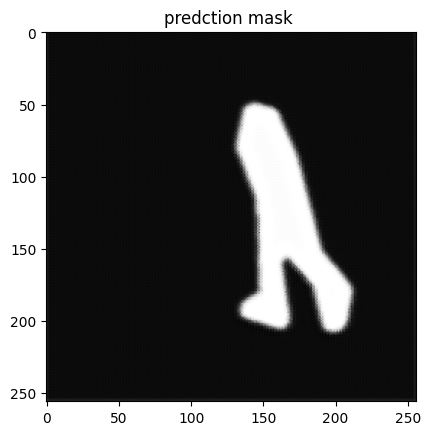

mask_loss = 0.8337823748588562, ordinary diffusion loss =0.08227664977312088


100%|██████████| 1/1 [00:14<00:00, 14.10s/it]


Epoch 7 finished with loss 0.0906


  0%|          | 0/1 [00:00<?, ?it/s]

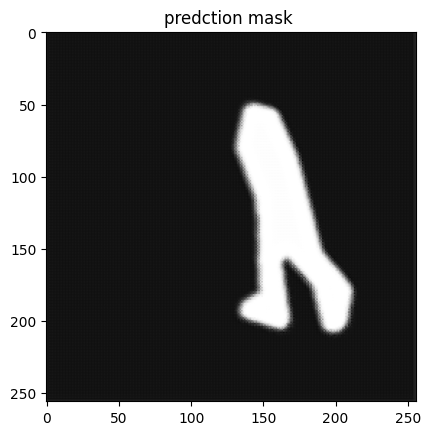

mask_loss = 0.8365527391433716, ordinary diffusion loss =0.07642465829849243


100%|██████████| 1/1 [00:13<00:00, 13.93s/it]


Epoch 8 finished with loss 0.0848


  0%|          | 0/1 [00:00<?, ?it/s]

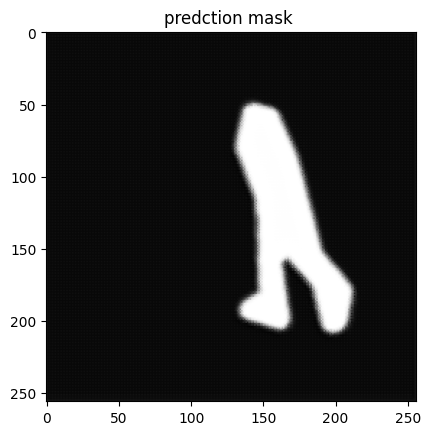

mask_loss = 0.8414685130119324, ordinary diffusion loss =0.07076654583215714


100%|██████████| 1/1 [00:13<00:00, 13.95s/it]


Epoch 9 finished with loss 0.0792


  0%|          | 0/1 [00:00<?, ?it/s]

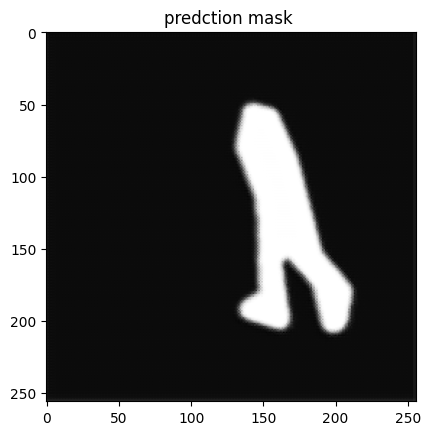

mask_loss = 0.8390272259712219, ordinary diffusion loss =0.06504711508750916


100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


Epoch 10 finished with loss 0.0734


  0%|          | 0/1 [00:00<?, ?it/s]

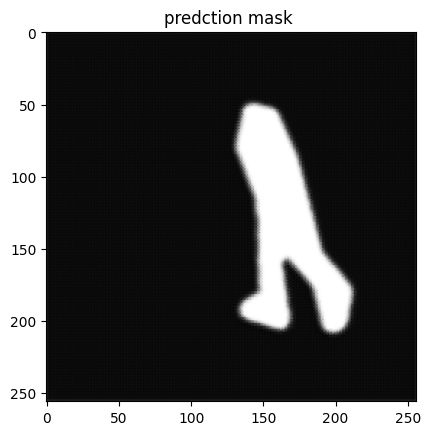

mask_loss = 0.8339029550552368, ordinary diffusion loss =0.07158166915178299


100%|██████████| 1/1 [00:13<00:00, 13.97s/it]


Epoch 11 finished with loss 0.0799


  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [8]:
#ground truth mask should not be the zero and 1 for loss convergence 

import torch
import os 
import gc
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision import models, transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
from data_loader import MaskedImageDataset
from different_level_mask import GaussianBlur
from diss_loss import DiceLoss
from u_net import Unet
from utilities import *
import matplotlib.pyplot as plt

def main():
    #device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    timesteps  = 500
    beta1 = 1e-4
    beta2 = 0.02
    b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device, dtype=torch.float32) + beta1
    a_t = 1 - b_t
    ab_t = torch.cumsum(a_t.log(), dim=0).exp().to(device)  
    ab_t[0] = 1
    beta1 = 1e-4
    beta2 = 0.02
    n_feat = 128
    batch_size = 1
    epochs = 20
    lrate=1e-4
    gamma = 0.01
    image_size=256 # no computing power for 256 need high computing power 
    height =image_size

    text_label = 'girl'

    checkpoint_dir ='/Users/chenyufeng/desktop/smartbrush/checkpoint'
    model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=512, height=height).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lrate)
    diss_loss=DiceLoss(device) 

    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
    m = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    inputs = processor(text=text_label, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_embeddings = m.get_text_features(**inputs).squeeze(0)

    
    x0_path = '/Users/chenyufeng/desktop/2.png'
    mask_s_path_1 = '/Users/chenyufeng/desktop/3.png'
    #mask_s_path_2 = '/Users/chenyufeng/desktop/4.png'
    ground_truth = '/Users/chenyufeng/desktop/1.png'



    def create_dataset(x0,mask,ground_truth_mask,text_embeddings,size,device):

        x0 = Image.open(x0).resize((size,size))

        x0_array = np.array(x0).astype(np.float32) / 255.0  
        x0 = torch.tensor(x0_array).permute(2, 0, 1).to(device)
        
        mask_image = Image.open(mask).resize((size,size))
        mask = np.array(mask_image).astype(np.float32) / 255.0
        mask = np.expand_dims(mask, axis=2)
        mask = torch.tensor(mask).permute(2, 0, 1).to(device)

        to_gray = transforms.Grayscale(num_output_channels=1)
        #mask = to_gray(mask)
        #mask = (torch.sigmoid(mask) > 0.5).float()  
        #mask = (torch.sigmoid(mask)).float()

        ground_truth_mask = Image.open(ground_truth_mask).resize((size,size))
        ground_truth_mask = torch.tensor(np.array(ground_truth_mask).astype(np.float32) / 255.0).permute(2, 0, 1).to(device)

        ground_truth_mask = to_gray(ground_truth_mask)
    
        #ground_truth_mask = (torch.sigmoid(ground_truth_mask) > 0.5).float()
        ground_truth_mask = (torch.sigmoid(ground_truth_mask)).float()
        return mask, text_embeddings, x0, ground_truth_mask 
    class CustomDataset(Dataset):
        def __init__(self, x0_path, mask_path, ground_truth_path, text_embeddings, size, device):
            self.data = create_dataset(x0_path, mask_path, ground_truth_path, text_embeddings, size, device)
    
        def __len__(self):
            return 1  
    
        def __getitem__(self, idx):
            return self.data


    d1 = CustomDataset(x0_path, mask_s_path_1, ground_truth, text_embeddings, image_size, device)
    mse_loss = nn.MSELoss()

    #dataset = ConcatDataset([d1，d2])
    dataloader = DataLoader(d1, batch_size=batch_size, shuffle=True)
    '''
    checkpoint_path = '/Users/chenyufeng/desktop/smartBrush/checkpoint/model_epoch_95.pth'  
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict']) 
        print(f'Checkpoint loaded from {checkpoint_path}')
    else:
        print(f'No checkpoint found at {checkpoint_path}, starting from scratch')'''

    model.train()
    for epoch in range(epochs):
        optim.param_groups[0]['lr'] = lrate * (1 - epoch / epochs)
        
        pbar = tqdm(dataloader, mininterval=2)
        epoch_loss = 0  
        '''
        x:blured mask 
        c:text 
        x0:original image
        mask:perfect mask 
        x->model->y  diceloss(y,mask)
        '''
        for x, c, x0,mask in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(x)
        
            context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
            c = c * context_mask.unsqueeze(-1)

            noise = torch.randn_like(x0)

            t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
            mask_background= (mask>0.5).float()
            xt = perturb_input(x0, t, noise,ab_t)
            xt = xt * mask_background + x0 * (1 - mask_background)

            pred_noise, pred_mask = model(xt, t/ timesteps , c, x)
            pred_mask = (torch.sigmoid(pred_mask)).float()
            pred_mask_background = (pred_mask>0.5).float()

            pred_mask_1= pred_mask.detach().cpu().numpy()[0, 0]  
            plt.imshow(pred_mask_1, cmap='gray')
            plt.title(f"predction mask ")
            plt.show()
    
            d_loss = diss_loss(pred_mask ,mask_background)
            f_loss =mse_loss(pred_noise * mask_background, noise * mask_background)
    
            loss = d_loss*0.01 + f_loss
            print(f'mask_loss = {d_loss}, ordinary diffusion loss ={f_loss}')
            loss.backward()
            optim.step()

            epoch_loss += loss.item() 
        avg_loss = epoch_loss /len(dataloader) 

        print(f"Epoch {epoch+1} finished with loss {avg_loss:.4f}")

        
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch + 1}.pth")
        save_checkpoint(model, optim, epoch + 1,avg_loss, checkpoint_path)

if __name__ == '__main__':
    main()

